### Meta

In [9]:
# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2


# Plotting code stolen from Georg's notebook.
import matplotlib.pyplot as plt


%matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 32}
plt.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [15]:
import sys
sys.path.insert(1, "..\\")


#import markov_clustering as mcl
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_theme()
import copy
import numpy as np


# Personal libraries
import lib.graph
import lib.files
import lib.centrality
import lib.cluster


In [11]:
# The first network is the largest connected component containing ICP55 with inviable proteins, has edges above 900 and no degree 0 nodes.
n0 = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks("icp55-cc-900-inv.txt"))

##Load in Julian O's df of key measures calculated on icp55 connected component, edge cutoff 900, keeping inviable proteins
network = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('icp55-cc-900-inv.txt'))
df = pd.read_csv(lib.files.path_to_tables('icp55-cc-900-inv.csv'), index_col=0, header=0)

## Validating bridging centrality

I want to know if bridging centrality does what we want it to - identify nodes that "bridge" clusters.

Methods:

Successively remove highest bridging centrality nodes in order, and see how it affects:

- Number of connected components
- Clustering coefficient (average)
- Mean shortest path between nodes
- Mean shortest path between clusters

In [72]:
#Sort statistics table df by bridging centrality
df_bridge_sort = df.sort_values(by = ["global_bridge_cent"],
              ascending = False)

In [98]:
#Make data frame to store sequential removal stats
removal_stats_df = pd.DataFrame({"protein_removed": df_bridge_sort["protein"],
                                "bridging_centrality_removed": df_bridge_sort["global_bridge_cent"],
                                "num_nodes_removed": range(len(df_bridge_sort.index) +1)[1:]})

#Sequential remove
removed_network = copy.deepcopy(network)
num_CC = []
avg_clust_coeff = []
for i in range(len(removal_stats_df.index)):
#for i in range(20):
    #removed_network = network.subgraph(list(removal_stats_df.iloc[(i + 1):, removal_stats_df.columns.get_loc("protein_removed")]))
    removed_network.remove_node(removal_stats_df.iloc[i, removal_stats_df.columns.get_loc("protein_removed")])
    
    #Number of connected components
    num_CC.append(nx.number_connected_components(removed_network))
    
    #Avg. clustering coefficient
    avg_clust_coeff.append(nx.average_clustering(removed_network))
    
df_bridge_sort["num_CC"] = num_CC
df_bridge_sort["avg_clust_coeff"] = avg_clust_coeff

ValueError: Length of values (20) does not match length of index (4572)

ValueError: Could not interpret value `avg_clust_coeff` for parameter `y`

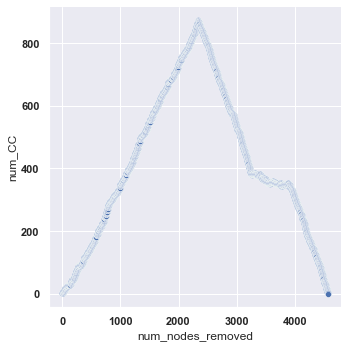

In [114]:
#Plot
sns.relplot(data = df_bridge_sort,
         x = "num_nodes_removed",
                   y = "num_CC")
sns.relplot(data = df_bridge_sort,
         x = "num_nodes_removed",
                   y = "avg_clust_coeff")

#### Are bridging nodes in clusters?

Ideally, bridging nodes should be positioned between clusters, not within them. I test that here.

0.0
0.0
0
0.0
2.983642017585321e-07
46
2.983642017585321e-07
1.0056122357558894e-05
1143
1.0056122357558894e-05
0.0292284201927191
1143


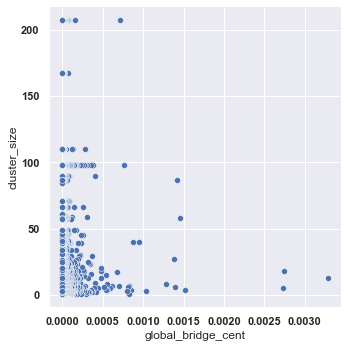

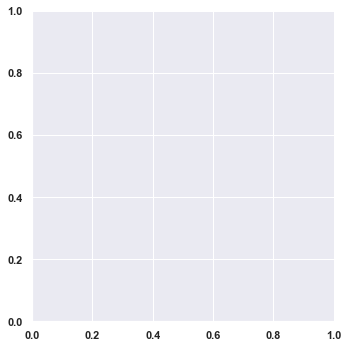

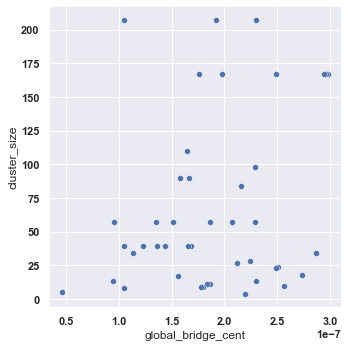

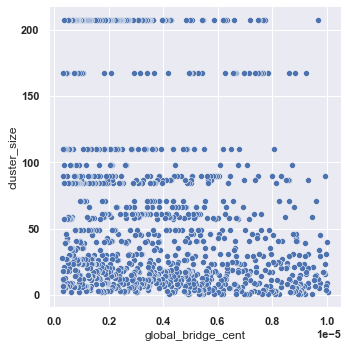

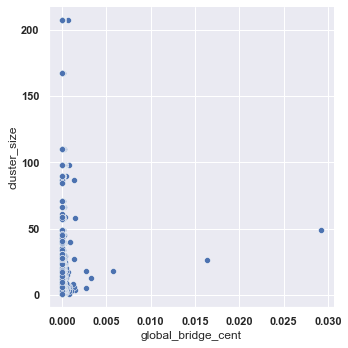

In [178]:
###Plot bridging centrality and cluster size

#Remove the 3 very high outliers
sns.relplot(data = df_bridge_sort.iloc[3:, ],
           x = "global_bridge_cent",
           y = "cluster_size")


#Plot between quantiles
##THIS IS NOT REALLY WORKING - MAYBE BECAUSE THEY ARE VERY SMALL VALUES?
num_quantiles = 4
for i in range(num_quantiles):
    
    upper_quant = df_bridge_sort["global_bridge_cent"].quantile((i + 1)/num_quantiles)
    lower_quant = df_bridge_sort["global_bridge_cent"].quantile((i)/num_quantiles)
    print(lower_quant)
    print(upper_quant)
    print(len(df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ].index))
    
    sns.relplot(data = df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ],
           x = "global_bridge_cent",
           y = "cluster_size")

So there is a trend for higher bridging centrality nodes to be in smaller clusters. But it is certainly just a trend.

In [180]:
df_bridge_sort.head()

,protein,deg,global_bet_cent,global_eig_cent,global_bridge_cent,icp55_shortest_path,pim1_shortest_path,inv,cluster,mcl_bet_cent,mcl_deg_cent,mcl_eig_cent,cluster_size,num_CC,num_nodes_removed,log_global_bridge_cent
4438,4932.YGR149W,2,0.001227,2.774237e-04,0.029228,5,4,0,14,0.0,0.020833,2.349291e-02,49,1,1,0.012512
4097,4932.YGL181W,3,0.000160,5.359596e-06,0.016347,4,4,0,32,0.0,0.000000,1.525555e-14,26,1,2,0.007042
2766,4932.YHR181W,2,0.002119,3.501464e-04,0.005800,5,5,0,58,0.0,0.058824,3.516647e-02,18,1,3,0.002512
1730,4932.YJL225C,7,0.028042,8.852234e-08,0.003288,6,4,0,84,0.0,0.250000,1.865115e-01,13,2,4,0.001425
1439,4932.YJR034W,9,0.000431,7.438327e-06,0.002740,3,3,0,54,0.0,0.235294,9.878016e-02,18,2,5,0.001188


## Exploring clusters related to ICP55 and PIM1

In [5]:
#Load network restricted to ICP55 and PIM1 3rd shell neighbours and clusters
network_restricted = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('mcl_shorpl_lte_3.icp55-cc-900-inv.csv'))
df_restricted = pd.read_csv(lib.files.make_filepath_to_networks('mcl_shorpl_lte_3.icp55-cc-900-inv.dataframe.csv'), index_col=0, header=0)

### Explore network of ICP55 and PIM1 2nd shell neighbours and clusters

False


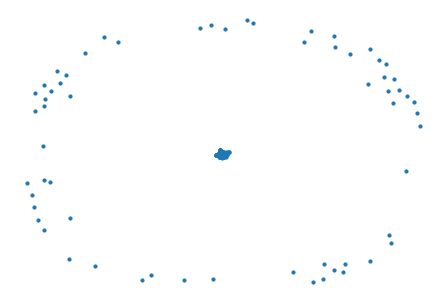

In [46]:
###CODE STOLEN FROM JULIAN O
#Get nth shell neighbours and clusters of icp55 and pim1. Don't force connected component at end
SHORPL_CUTOFF = 2

network_name = 'icp55-cc-900-inv'
network_filepath = lib.files.make_filepath_to_networks(f'{network_name}.txt')
cluster_filepath = lib.files.make_filepath_to_clusters(f'mcl.{network_name}.nodes.csv')
cluster_df_filepath = lib.files.make_filepath_to_clusters(f'mcl.{network_name}.dataframe.csv')

network = lib.graph.read_weighted_edgelist(network_filepath)
clusters = lib.cluster.read_csv(cluster_filepath)
cluster_df = pd.read_csv(cluster_df_filepath, header=0, index_col=0)

condition_1 = cluster_df['size'] > 5
condition_2 = (cluster_df['icp55_shorpl'] <= SHORPL_CUTOFF) | (cluster_df['pim1_shorpl'] <= SHORPL_CUTOFF)
relevant_cluster_df = cluster_df[condition_1 & condition_2]
relevant_clusters = [clusters[idx] for idx in relevant_cluster_df['cluster']]

relevant_proteins = set()
relevant_proteins.update(lib.cluster.proteins(relevant_clusters))
relevant_proteins.update(lib.graph.get_neighbourhood(network, lib.constants.ICP55, SHORPL_CUTOFF))
relevant_proteins.update(lib.graph.get_neighbourhood(network, lib.constants.PIM1, SHORPL_CUTOFF))
#relevant_cluster_network = lib.graph.get_largest_connected_component(network.subgraph(relevant_proteins))
relevant_cluster_network = network.subgraph(relevant_proteins)


nx.draw(relevant_cluster_network,
       node_size = 10)
print(nx.is_connected(relevant_cluster_network))

In [40]:
print(relevant_cluster_network.number_of_nodes())

338


In [44]:
#Comparing shortest paths for nodes and clusters
print(df[df["pim1_shortest_path"] <= 1])
print(cluster_df[cluster_df["pim1_shorpl"] <= 1])

           protein  deg  global_bet_cent  global_eig_cent  global_bridge_cent  \
25    4932.YGL043W   52         0.001266     2.650834e-04        7.663277e-07   
26    4932.YBL022C    9         0.001879     9.201928e-06        2.124451e-04   
37    4932.YER164W   46         0.001789     6.615033e-04        5.265994e-06   
1107  4932.YLR259C   62         0.013943     5.610348e-04        8.691371e-04   
1300  4932.YBR227C    7         0.000252     1.804154e-06        0.000000e+00   
1355  4932.YMR089C    5         0.000040     8.562936e-07        0.000000e+00   
1357  4932.YER017C    7         0.000080     1.076970e-06        0.000000e+00   
1403  4932.YPR024W   13         0.001712     3.830463e-06        3.285593e-05   
1914  4932.YDL015C   11         0.002579     1.038764e-05        6.772538e-05   
1915  4932.YNL295W    3         0.000459     5.851539e-08        4.528267e-05   

      icp55_shortest_path  pim1_shortest_path  inv  cluster  mcl_bet_cent  \
25                      4      

True
True
False
False
False
True
False
False
False
False


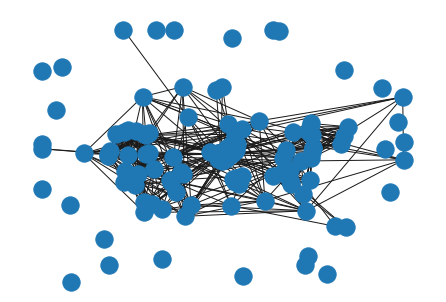

In [56]:
###Are clusters connected?
for i in range(10):
        print(nx.is_connected(network.subgraph(clusters[i])))
        nx.draw(network.subgraph(clusters[i]))